In [1]:
""" Inflation Prediction Study
Author: Camilla Nore
Date:   2015-08-30
"""
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

#%matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 5.0)

# NB: As this is iPython, the module will be cached. If you change 
#     the module, you have to restart the iPython kernel.
from inflastudy import InflaData  # Custom module for this study.
from inflastudy import decode_column_name # Decode column name
from inflastudy import NaivePredictions
from inflastudy import error_calculation

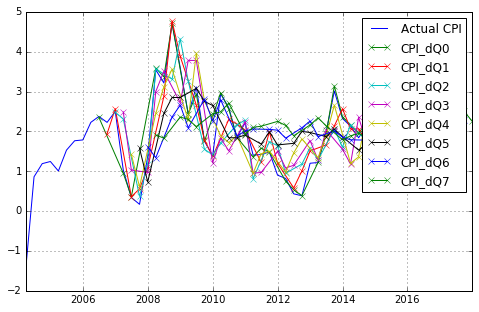

In [2]:
""" Load the data file"""

data = InflaData.InflaData(filename='data/kongepanel_upd_oppdatert_mars.csv')
data.calc_relative_data()

data.plot_relative_time_cpi_data()

#print data.raw_data.CPI       # Uncomment this line to see raw CPI data.
#print data.raw_data.columns   # Uncomment this line to see column names.
#print(data.cpi_pred_relative)

In [3]:
# Calculate naive values and error
actual_cpi = data.raw_data['CPI']
naive_cpi = NaivePredictions.NaivePredictions(actual_cpi, col_prefix='CPI-naive_dQ')
naive_error_cpi = error_calculation.PredictionError(naive_cpi.data, naive_cpi.data['CPI'])
naive_jae = NaivePredictions.NaivePredictions(data.raw_data['CPI-jae'], col_prefix='jae-naive_dQ')
naive_error_jae = error_calculation.PredictionError(naive_jae.data, naive_jae.data['CPI-jae'])
naive_gap = NaivePredictions.NaivePredictions(data.raw_data['Produksjonsgap'], col_prefix='gap-naive_dQ', target = 0.0)
naive_error_gap = error_calculation.PredictionError(naive_gap.data, naive_gap.data['Produksjonsgap'])

In [4]:
# Calculate error
cpi_error = error_calculation.PredictionError(data.cpi_pred_relative, data.raw_data['CPI'])
jae_error = error_calculation.PredictionError(data.jae_pred_relative, data.raw_data['CPI-jae'])
gap_error = error_calculation.PredictionError(data.gap_pred_relative, data.raw_data['Produksjonsgap'])

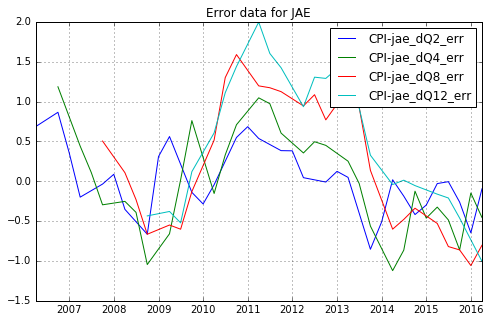

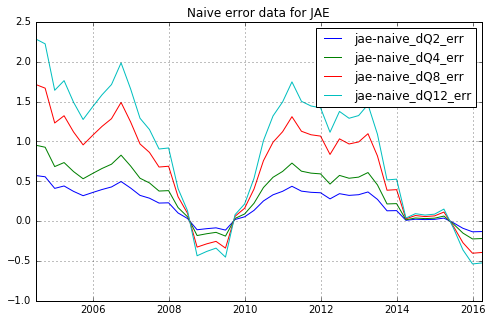

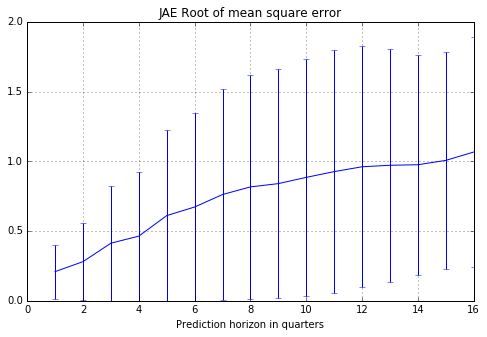

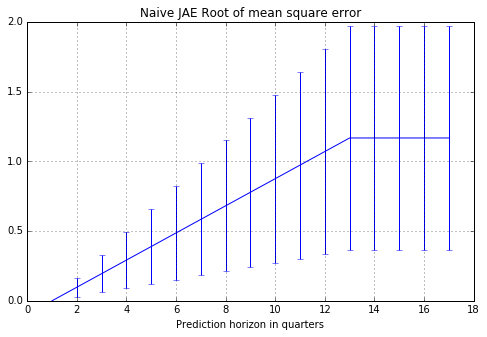

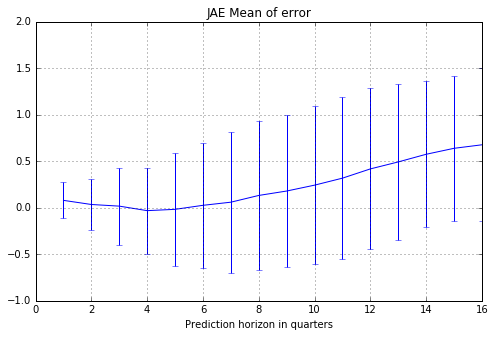

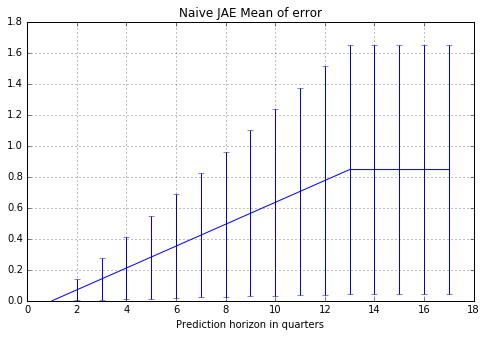

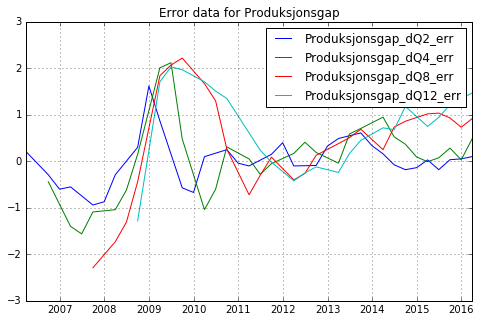

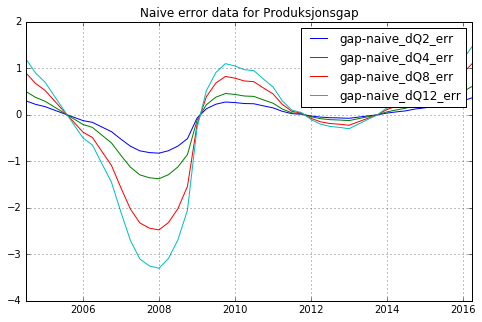

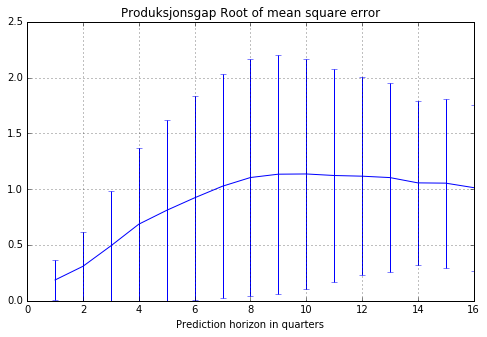

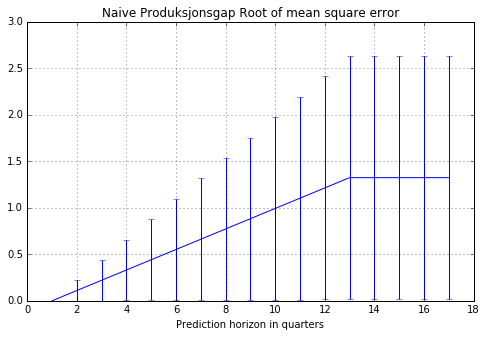

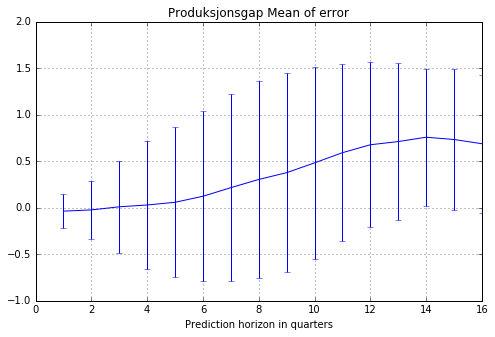

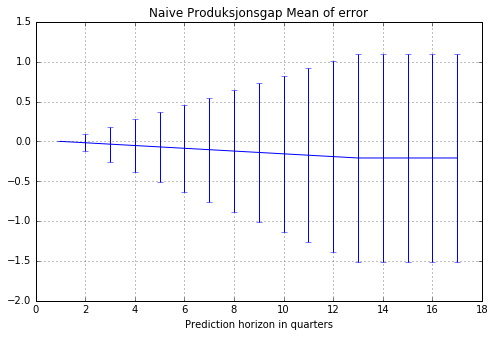

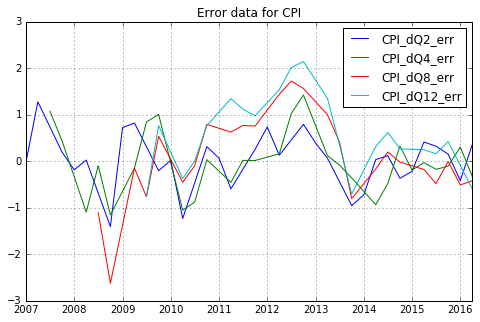

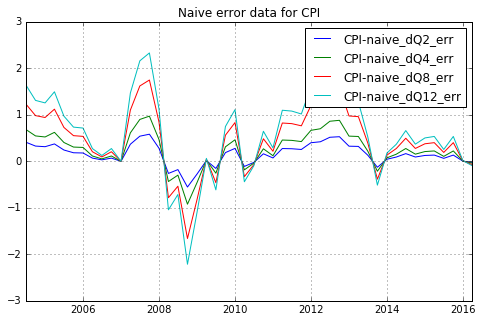

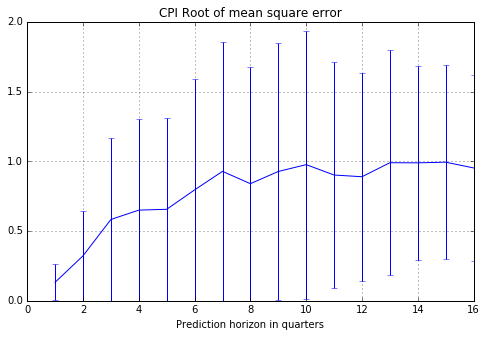

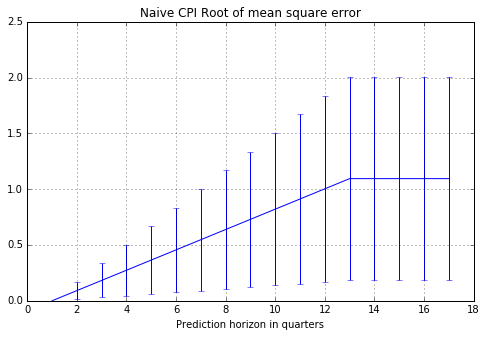

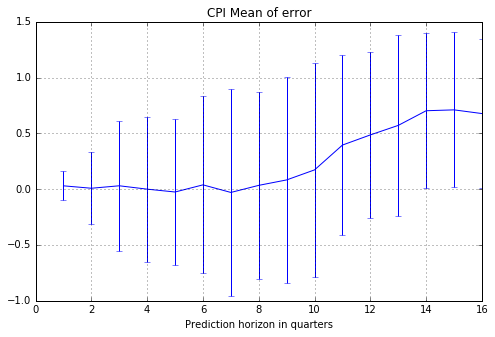

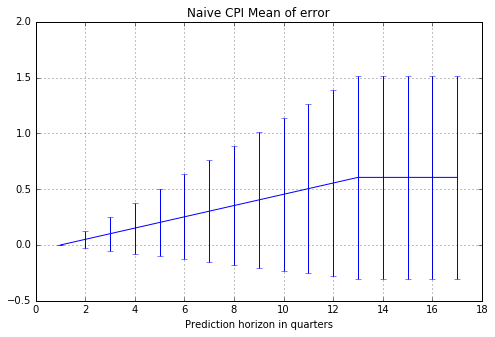

In [12]:
# Plot and compare with naive.
stashes = {'CPI':{'error':cpi_error, 'naive':naive_cpi, 
                  'naive_error':naive_error_cpi, 'data':data.cpi_pred_relative},
           'JAE':{'error':jae_error, 'naive':naive_jae, 
                  'naive_error':naive_error_jae, 'data':data.cpi_jae_predictions},
           'Produksjonsgap':{'error':gap_error, 'naive':naive_gap, 
                             'naive_error':naive_error_gap, 'data':data.gap_pred_relative}}
for key in stashes:
    stashes[key]['error'].plot_selected(plot_title='Error data for '+key)
    stashes[key]['naive_error'].plot_selected(plot_title='Naive error data for '+key)
    
    stashes[key]['error'].plot_rms(title_prefix=key+' ')
    stashes[key]['naive_error'].plot_rms(title_prefix='Naive '+key+' ')
    
    stashes[key]['error'].plot_mean(title_prefix=key+' ')
    stashes[key]['naive_error'].plot_mean(title_prefix='Naive '+key+' ')
    
    # Save as Excel sheet.
    stashes[key]['data'].to_excel('output/'+key+'_relative.xlsx')
    stashes[key]['error'].pred_error.to_excel('output/'+key+'_error.xlsx')
    stashes[key]['naive'].data.to_excel('output/'+key+'_naive.xlsx')
    stashes[key]['naive_error'].pred_error.to_excel('output/'+key+'_naive_error.xlsx')

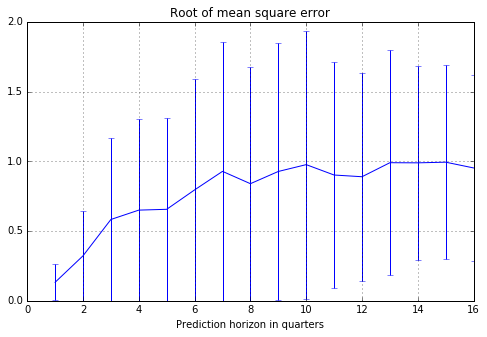

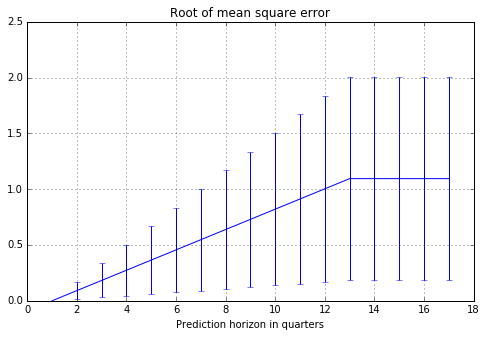

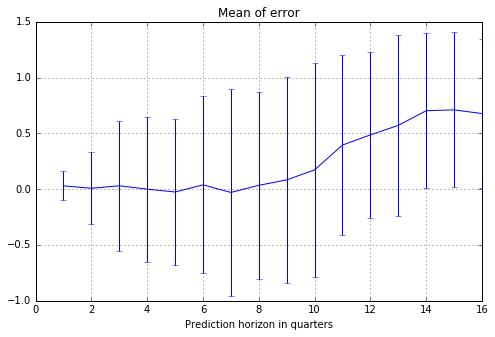

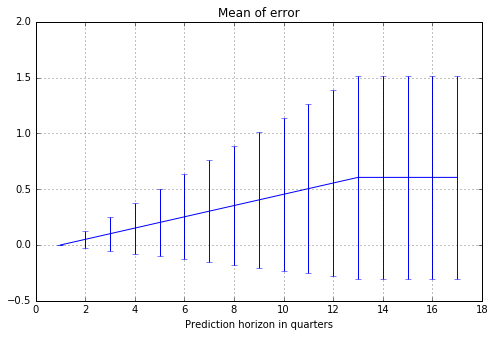

In [6]:
# Plot and compare rms with naive
cpi_error.plot_rms()
naive_error_cpi.plot_rms()

#Plot and compare the mean with naive
cpi_error.plot_mean()
naive_error_cpi.plot_mean()

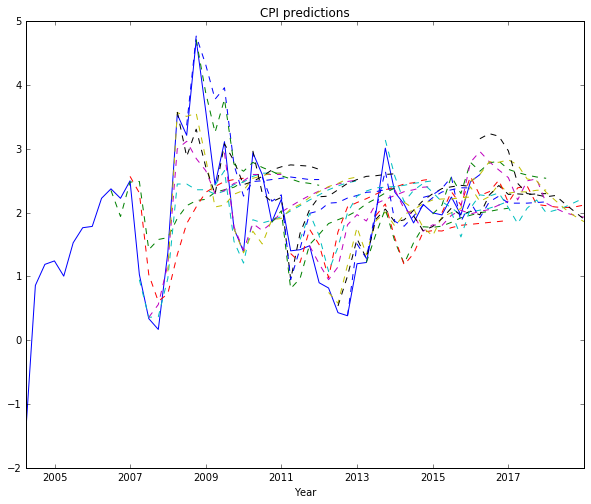

In [8]:
""" Plot all CPI predictions and the actual CPI. """

plt.figure('CPI predictions', figsize=(10,8))  # Larger plot.
plt.title('CPI predictions')
plt.xlabel('Year')
# Plot the actual CPI as a solid line.
plt.plot(data.raw_data.index,
         data.raw_data['CPI'],
         label ='CPI')

for col_name in data.cpi_predictions:
    plt.plot(data.cpi_predictions.index,
             data.cpi_predictions[col_name],
             '--',
             label = 'col_name')

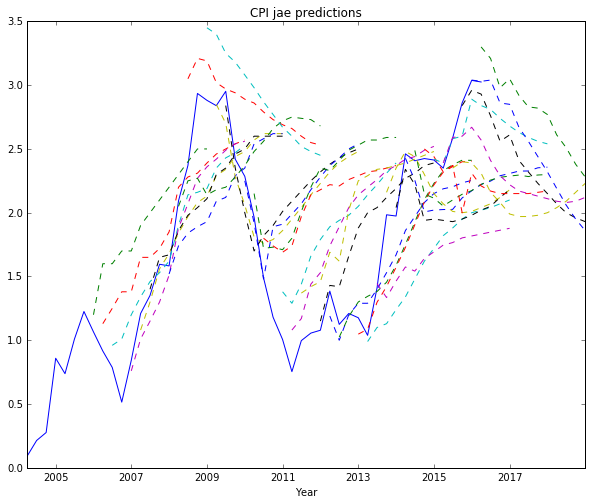

In [9]:
""" Plot all CPI-jae predictions and the actual CPI-jae. """

plt.figure('CPI jae predictions', figsize=(10,8))  # Larger plot.
plt.title('CPI jae predictions')
plt.xlabel('Year')

# Plot the actual CPI as a solid line.
plt.plot(data.raw_data.index,
         data.raw_data['CPI-jae'],
         label ='CPI jae')

for col_name in data.cpi_jae_predictions:
    plt.plot(data.cpi_jae_predictions.index,
             data.cpi_jae_predictions[col_name],
             '--',
             label = 'col_name')
